<a href="https://colab.research.google.com/github/woongjoonchoi/DeepLearningPaper-Reproducing/blob/master/Vgg/Singe_evaluation_and_multi_scale_evaluation_multi_crop_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import albumentations as A
import numpy as np

import matplotlib.pyplot as plt
from torchvision.datasets import Caltech256 ,Caltech101 ,CIFAR100
import os
from PIL import Image
from urllib.request import urlretrieve
import requests
import tarfile

In [26]:
from torch.utils.data import Subset

In [15]:
from sklearn.model_selection import train_test_split

In [63]:
trans_single=A.Compose(
    [
        A.SmallestMaxSize(max_size=256),
        A.RandomCrop(height =256,width=256),
        A.HorizontalFlip(),
        A.RGBShift()
    ]

)

## File Download manually from caltech

In [6]:
os.makedirs(os.path.join(os.getcwd(),'caltech256'))
file_url = "https://data.caltech.edu/records/nyy15-4j048/files/256_ObjectCategories.tar?download=1"

r = requests.get(file_url, stream = True)
with open(os.path.join(os.getcwd(),'caltech256','256_ObjectCategories.tar'),"w+b") as f:
    for chunk in r.iter_content(chunk_size=1024):
        if chunk:
            f.write(chunk)
with tarfile.open(os.path.join(os.getcwd(),'caltech256','256_ObjectCategories.tar') ,'r') as f:
    f.extractall(os.path.join(os.getcwd(),'caltech256'))

## Evaluation

In [74]:
class Custom_Caltech(Caltech256) :
    def __init__(self,root,transform=None,multi=False,s_max=None,s_min=256,train=True,val=False):

        super().__init__(root,transform=transform)
        self.multi = multi
        self.s_max = s_max
        self.s_min= s_min
    def __getitem__(self, index: int) :
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img = Image.open(
            os.path.join(
                self.root,
                "256_ObjectCategories",
                self.categories[self.y[index]],
                f"{self.y[index] + 1:03d}_{self.index[index]:04d}.jpg",
            )
        )
        img=np.array(img)
        # print(img.shape)
        target = self.y[index]
        if self.transform is not None:
            S=None
            if self.multi :
                if self.train :
                    print('multi scale')
                    S = np.random.randint(low=self.s_min,high=self.s_max)
                    img = A.SmallestMaxSize(max_size=S)(image=img)['image']
                elif self.val :
                    img = A.SmallestMaxSize(max_size=self.s_min)(image=img)['image']
            elif min(img.shape[0],img.shape[1]) <self.s_min :
                print(f'less than {self.s_min}')
                img = A.SmallestMaxSize(max_size=self.s_min)(image=img)['image']
            else :
                print(f'bigger than {self.s_min}')
            img = self.transform(image=img)


        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

In [64]:
real_caltech = Custom_Caltech(root=os.getcwd(),transform=trans_single)

In [14]:
real_caltech[20000]

(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=606x315>, 172)

### Train-val split


In [16]:
target_list = []
for _,target in real_caltech :
    target_list.append(target)


In [19]:
X_train,X_test  = train_test_split(list(range(len(real_caltech)))  ,test_size=0.2,random_state= 42,stratify=target_list)

In [65]:
train_data ,val_data = Subset(real_caltech,X_train) ,Subset(real_caltech,X_test)

### train-single 256


In [46]:
train_data.dataset.s_min = 256

In [47]:
val_data.dataset.s_min = 256

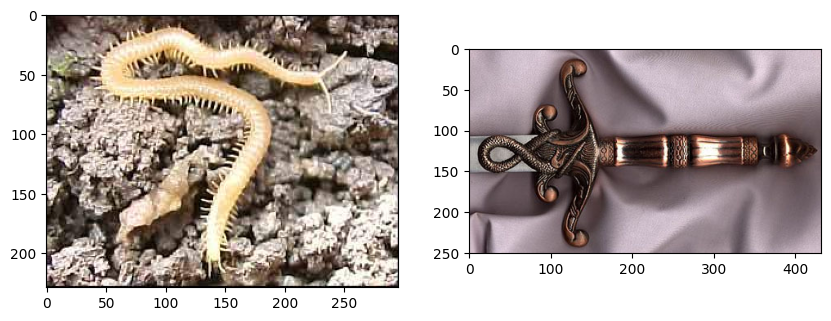

In [54]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)

plt.imshow(train_data[0][0])

plt.subplot(1,2,2)
plt.imshow(val_data[0][0])

### train-single 384


In [75]:
trans_single=A.Compose(
    [
        A.SmallestMaxSize(max_size=384),
        A.RandomCrop(height =384,width=384),
        A.HorizontalFlip(),
        A.RGBShift()
    ]

)

In [76]:
real_caltech = Custom_Caltech(root=os.getcwd(),transform=trans_single)

In [79]:
train_data ,val_data = Subset(real_caltech,X_train) ,Subset(real_caltech,X_test)

In [80]:
val_data.dataset.s_min = 384

In [81]:
train_data.dataset.s_min = 384

less than 384
less than 384


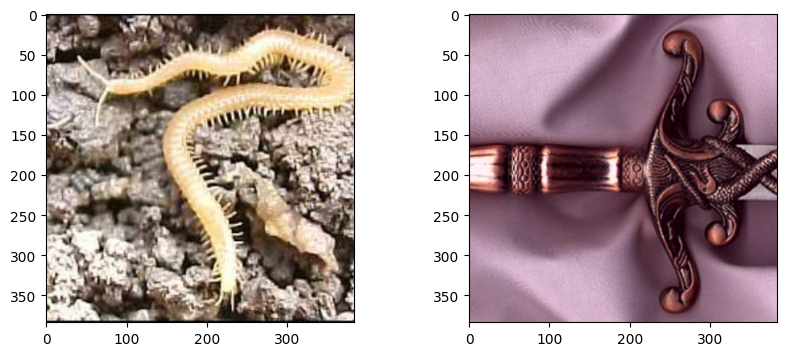

In [82]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(train_data[0][0]['image'])

plt.subplot(1,2,2)
plt.imshow(val_data[0][0]['image'])

### train-multi 256,512

### Mutli-crop


In [83]:
trans_single=A.Compose(
    [
        A.SmallestMaxSize(max_size=384),
        A.RandomCrop(height =384,width=384),
        A.HorizontalFlip(),
        A.RGBShift()
    ]

)

In [84]:
real_caltech = Custom_Caltech(root=os.getcwd(),transform=trans_single)

In [85]:
train_data ,val_data = Subset(real_caltech,X_train) ,Subset(real_caltech,X_test)

In [86]:
val_data.dataset.s_min = 384

In [87]:
train_data.dataset.s_min = 384

In [109]:
li =[]
length = 383
for i in range(5) :
    li.append(383-i*384//5)
    # length-=384//5

In [110]:
li.append(0)

In [111]:
li.reverse()

In [112]:
li

[0, 76, 153, 230, 307, 383]

In [125]:
grid_flip_list = []
temp_image =train_data[0][0]['image']
for i in range(len(li)-1) :
    for j in range(len(li)-1) :
        cropped_image = A.Crop(x_min=li[i],x_max=li[i+1],y_min=li[j] ,y_max = li[j+1])(image=temp_image)
        grid_flip_list.append(cropped_image)
        grid_flip_list.append(A.HorizontalFlip(p=1)(image=cropped_image['image']))

less than 384


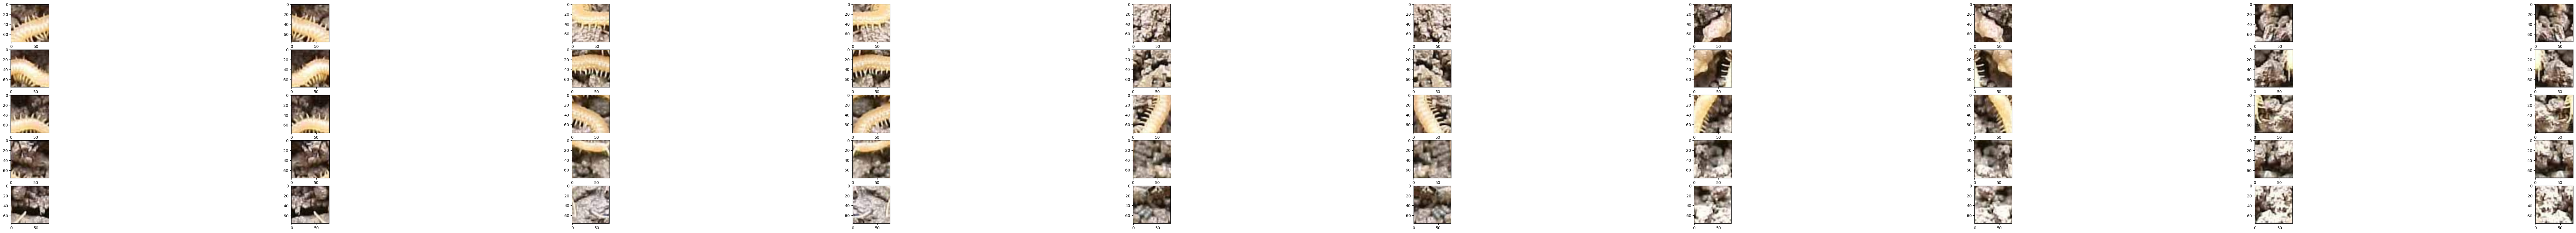

In [126]:
plt.figure(figsize=(125,10) )
for i in range(50):
    plt.subplot(5,10  , i+1)
    plt.imshow(grid_flip_list[i]['image'])
